<img align="left" src="img/ECE364-logo.png" width="300px" style="padding:30px;border:thin solid white;"> 

# Lecture 8 - Linear Classification II
## ECE364 - Programming Methods for Machine Learning
### Nickvash Kani 












###### Slides based off prior lectures by Alex Schwing, Aigou Han, Farzad Kamalabadi, Corey Snyder. All mistakes are my own!

Thigns we will cover: 

- Multi-parameter linear regression
- Polnomial regression 
- Regularization

## Multi-parameter linear regression

Last lecture we discussed linear regression and specifically we focused on one-dimensional linear fits: 

$$
y = mx + b
$$

This is called **simple linear regression**.  

When we have multiple input parameters that we wish to regress on: 

$$
y = m_nx_n \ldots + m_3x_3 + m_2x_2 + m_1x_1 + b
$$

This is called **multiple linear regression**. 

Initial guesses: w0=-0.490302, w1=-0.226434, w2=-0.529657
Final guesses: w0=0.192389, w1=3.349462, w2=1.125687


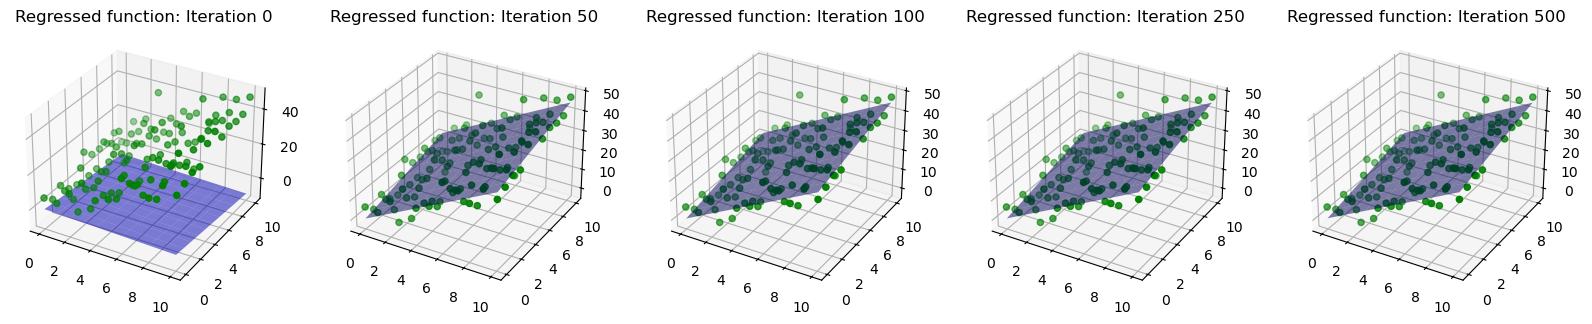

In [118]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# dataset we are artificially creating: 
# Set seed for reproducibility
np.random.seed(42)

# Generate 10 x values between 0 and 10
DN=11
x = torch.linspace(0, 10, DN)
y = torch.linspace(0, 10, DN)
points = torch.stack(torch.meshgrid(x, y)).T.reshape(-1,2)
X = torch.column_stack((torch.ones(points.shape[0]), points))
N = X.shape[0]
#print(X)

# Generate true target values with some noise
true_m1 = 3
true_m2 = 1
true_b = 3

t = torch.clone(true_m2 * X[:,2] + true_m1 * X[:,1] + true_b + np.random.normal(0, 6, size=len(X)))

# initialize guesses for w, b
w_gd = torch.randn((3), requires_grad=True) # size (1,)
print('Initial guesses: w0={:.6f}, w1={:.6f}, w2={:.6f}'.format(w_gd[0].data, w_gd[1].data, w_gd[2].data))

# information for tracking
b_vals = [w_gd[0].data.item()]
w1_vals = [w_gd[1].data.item()]
w2_vals = [w_gd[2].data.item()]

# gradient descent loop
n_iter = 10000 # number of iterations
alpha = 10e-3 # step size
for n in range(n_iter):
    errors = t-(X@w_gd)
    loss = torch.sum((errors)**2)/N
    loss.backward()
    with torch.no_grad():
        w_gd -= alpha*w_gd.grad
        w_gd.grad = None
        
    # log information
    w2_vals.append(w_gd[2].data.item())
    w1_vals.append(w_gd[1].data.item())
    b_vals.append(w_gd[0].data.item())
    
# examine solution
print('Final guesses: w0={:.6f}, w1={:.6f}, w2={:.6f}'.format(w_gd[0].data, w_gd[1].data, w_gd[2].data))

iter_num = np.array([0, 50, 100, 250, 500]).astype(int)
plt.figure(figsize=(20, 5))
for j, i in enumerate(iter_num):
    ax = plt.subplot(1, 5, j+1, projection='3d')
    ax.scatter(X[:,1].detach().numpy(), X[:,2].detach().numpy(), t, color='green')
    xx, yy = torch.meshgrid(x, y)
    curr_fn = w2_vals[i]*yy + w1_vals[i]*xx + b_vals[i]
    ax.plot_surface(xx, yy, curr_fn.detach().numpy(), color='blue', alpha=0.5)
    plt.grid(True)
    plt.title('Regressed function: Iteration {}'.format(i))

In [18]:
print(x.dtype)
print(t.dtype)
W = torch.linalg.inv(X.t()@X)@X.t()@t
print(W)

torch.float32
torch.float32
tensor([0.1924, 3.3495, 1.1257])


## Linear regress all the things!

<img align="center" src="./img/Linear_regress_everything.png" width="600px" style="padding:30px;border:thin solid white;"> 


In [31]:
from sklearn.datasets import fetch_california_housing
import torch

# Load the dataset
california_housing = fetch_california_housing()

# Extract features and target
X = california_housing.data
t = california_housing.target

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
t_tensor = torch.tensor(t, dtype=torch.float32).view(-1, 1)

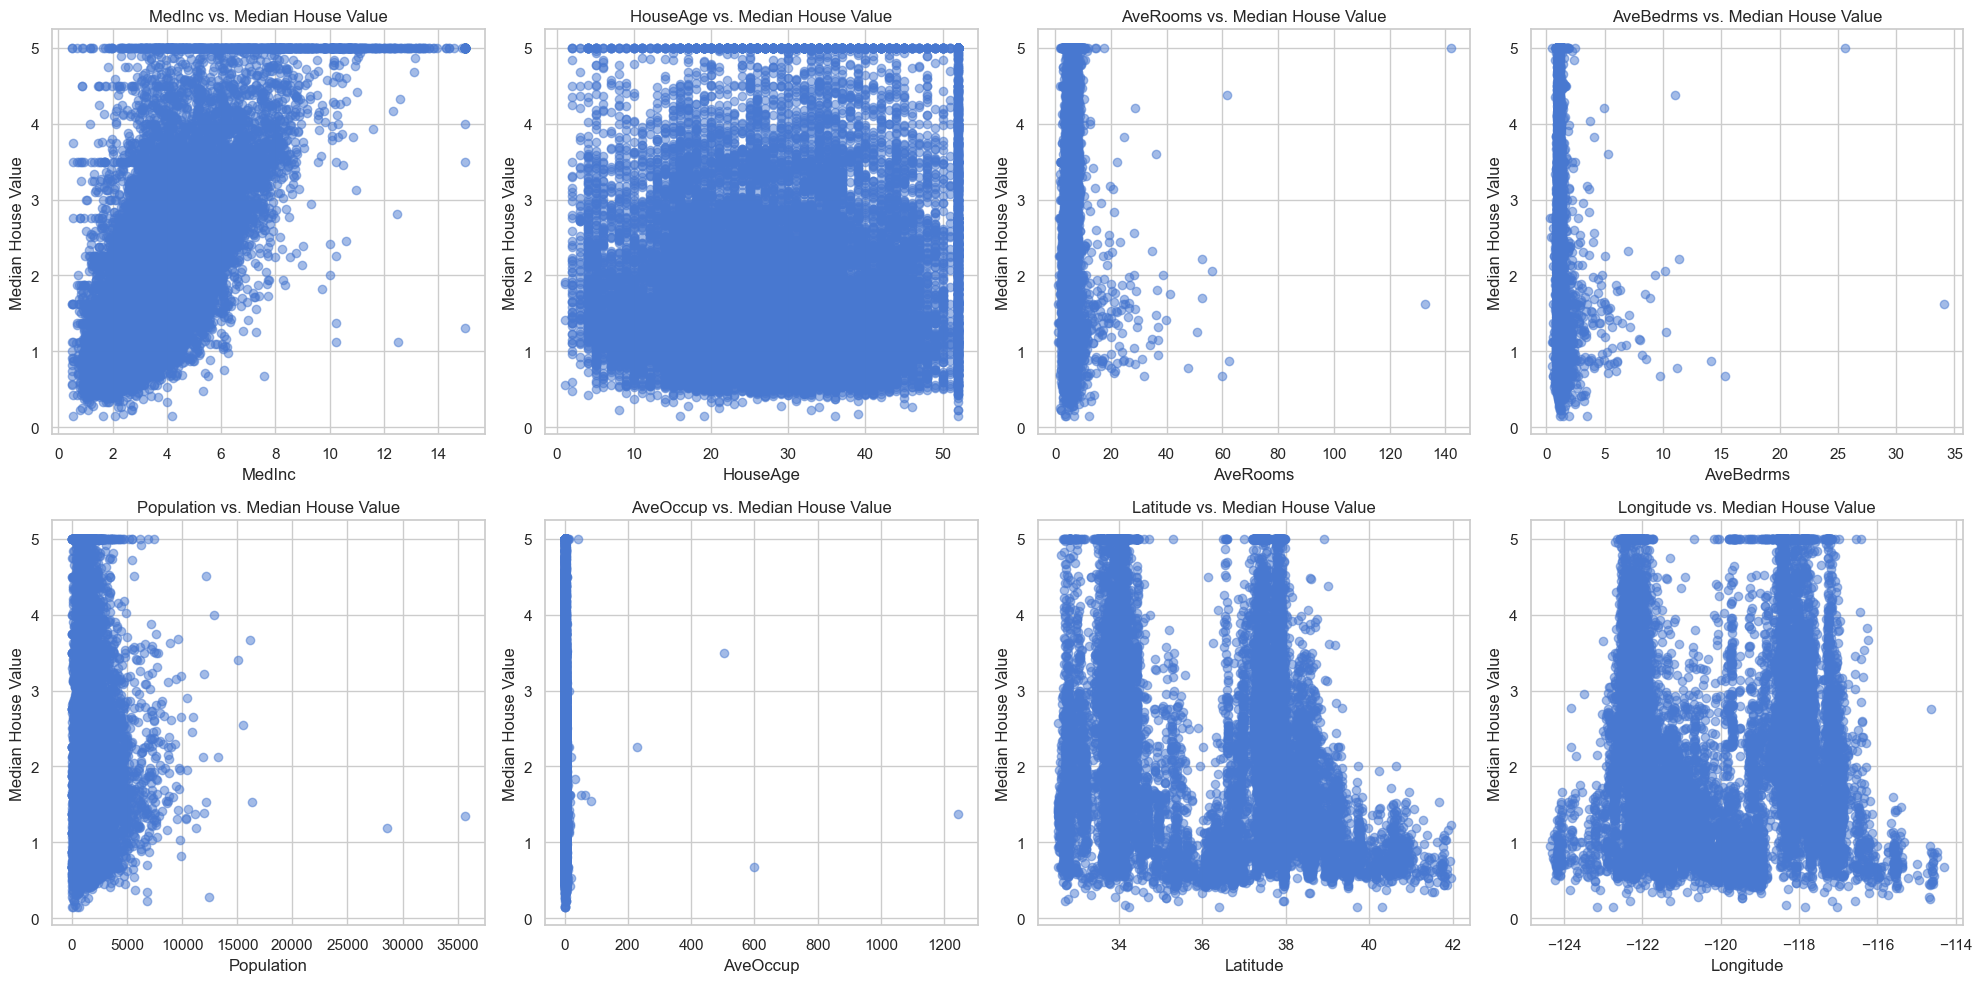

In [32]:
import matplotlib.pyplot as plt

# Feature names
feature_names = california_housing.feature_names

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

# Plot each feature against the target
for i, feature in enumerate(feature_names):
    axes[i].scatter(X[:, i], y, alpha=0.5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Median House Value')
    axes[i].set_title(f'{feature} vs. Median House Value')

# Adjust layout
plt.tight_layout()
plt.show()


In [53]:
N = X_tensor.shape[0]
X = torch.column_stack((torch.ones(N), X_tensor))

w_gd = torch.randn((X_tensor.shape[1]+1), requires_grad=True) # size (1,)
print('Initial guesses: ' + str(w_gd))
# information for tracking
w_vals = []
w_vals.append(w_gd.detach().numpy())
loss_vals = []

# gradient descent loop
n_iter = 20 # number of iterations
alpha = 10e-3 # step size
for n in range(n_iter):
    # compute loss function (objective function)
    errors = t_tensor-(w_gd*X)
    loss = torch.sum((errors)**2)/N
    # backpropagate gradients
    loss.backward()
    # perform gradient descent update step
    with torch.no_grad():
        # don't want the gradient update step to accumulate further gradients at a, b, and c
        w_gd -= alpha*w_gd.grad
        # manually zero out the gradients before next backward pass
        w_gd.grad = None
        
    # log information
    loss_vals.append(loss.item()) # log MSE
    w_vals.append(w_gd.detach().numpy())
    
# examine solution
print('Final guesses: ' + str(w_gd))

Initial guesses: tensor([ 1.2498, -0.7285, -1.9997, -0.4959,  0.0064,  1.4592,  0.5654, -0.3509,
        -0.7465], requires_grad=True)
Final guesses: tensor([ 1.5220e+00,  5.1169e-01, -4.9149e+25,  3.2768e-01,  6.9450e-01,
                nan,  1.9539e+02, -2.4478e+27,         nan],
       requires_grad=True)


In [44]:
W = torch.linalg.inv(X.t()@X)@X.t()@t_tensor
print(W)

tensor([[-3.7287e+01],
        [ 4.3591e-01],
        [ 9.3907e-03],
        [-1.0650e-01],
        [ 6.4251e-01],
        [-2.4554e-06],
        [-3.7776e-03],
        [-4.2472e-01],
        [-4.3840e-01]])


<img align="center" src="./img/Linear_regress_maybe_not.png" width="600px" style="padding:30px;border:thin solid white;"> 

* Credit to Allie Brosh from [Hyperbole and a Half](https://hyperboleandahalf.blogspot.com/)

## Polynomial fitting

Suppose we had the following plot: 

<img align="middle" src="./img/scatter_plot_with_sample_polynomial_no_lines.png" width="500px" style="padding:30px;border:thin solid white;"> 

Linear model here would probably be less than ideal...... what do we do? 

Linear model here is less than ideal...... what do we do? 

<img align="middle" src="./img/poly_fit_1.png" width="500px" style="padding:30px;border:thin solid white;"> 

Well think of the last few lectures. We had plenty of complex functions we fitted our data to .... What were we doing then?

A complex polynomial is simply the combination of a bunch of powers of $x$. So if we can combination linear functions together together, why not combine polynomial function together also?

We do this by augmenting our prior work using a feature map: 

$$\phi(x) = \begin{pmatrix} 1 \\ x \\ x^2 \\ x^3 \end{pmatrix}$$

making the regression model: 

$$ y = w^T \phi(x) $$

All of the derivations in the lecture so far are going to remain the same!

Initial guesses: tensor([ 1.3396, -0.1014, -0.8522, -0.8095], requires_grad=True)
Final guesses: tensor([ 23.7810, -10.0547,  -0.4786,   0.2501], requires_grad=True)


Text(0.5, 1.0, 'Regressed function: w_0')

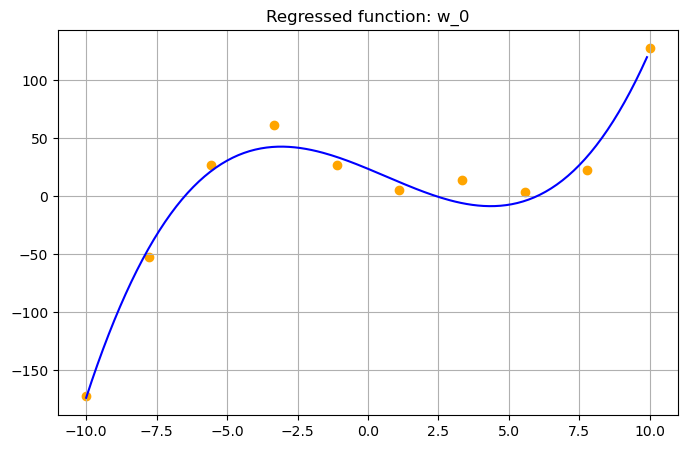

In [123]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# dataset we are artificially creating: 
# Set seed for reproducibility
np.random.seed(42)

N=10
# Generate 10 x values between 0 and 10
x = torch.linspace(-10, 10, N)

# Generate y values with some variability
def f(x): 
    return 0.25 * x **3 + -0.5 * x**2 + -10 * x + 20 

t = torch.clone(f(x) + np.random.normal(0, 15, size=len(x)))

#Set polynomial order (2 means we want a fitting function w3 x^3 + w2 x^2 + w1 x + w0)
order = 3

def f_fit(w, x):
    out = w[0]
    for i in (1+np.arange(order)):
        a = w[i] * x**i
        b = out
        out = a + b 
    return out

# initialize guesses for w, b
w_gd = torch.randn((order+1), requires_grad=True) # size (1,)
print('Initial guesses: ' + str(w_gd))

n_iter = 200000 # number of iterations
alpha = 1e-6 # step size
momentum = 0.9
velocity = torch.zeros(order+1)
w_vals = []
w_vals.append(w_gd.detach().numpy().copy())
for n in range(n_iter):
    y = sum(w_gd[i] * x**i for i in torch.arange(order+1))
    errors = t-y
    loss = torch.sum((errors)**2)/N
    loss.backward()
    with torch.no_grad():
        velocity.mul_(momentum).add_(w_gd.grad, alpha=-alpha)
        w_gd.add_(velocity)        
        w_gd.grad.zero_()
    w_vals.append(w_gd.detach().numpy().copy())
    
# examine solution
print('Final guesses: ' + str(w_gd))

plt.figure(figsize=(8, 5))
plt.subplot(1, 1,1)
xx = np.arange(-10,10,0.1)
curr_fn = np.zeros_like(xx)
for k in range(xx.shape[0]):
    curr_fn[k] = sum(w_gd[a] * xx[k]**a for a in np.arange(order+1))
plt.plot(xx, curr_fn, color='blue')
plt.scatter(x.detach().numpy(), t, color='orange')
plt.grid(True)
plt.title('Regressed function: w_0'.format(i))

# iter_num = np.array([0, 20000, 40000, 100000, 200000]).astype(int)
# plt.figure(figsize=(20, 5))
# for j, i in enumerate(iter_num):
#     plt.subplot(1, 5, j+1)
#     curr_fn = w_vals[i]*x + b_vals[i]
#     plt.plot(x.detach().numpy(), curr_fn.detach().numpy(), color='blue')
#     plt.scatter(x.detach().numpy(), t, color='orange')
#     plt.grid(True)
#     plt.title('Regressed function: Iteration {}'.format(i))

[ 0.6529619  -1.364675   -0.62764525  0.14843452]
[ 1.8479408  -5.309503   -0.17538156  0.19427092]
[ 5.123281   -9.287068   -0.2206618   0.24108562]
[ 10.516496   -10.038336    -0.29522064   0.2499278 ]
[ 23.66065    -10.054739    -0.4769331    0.25012088]


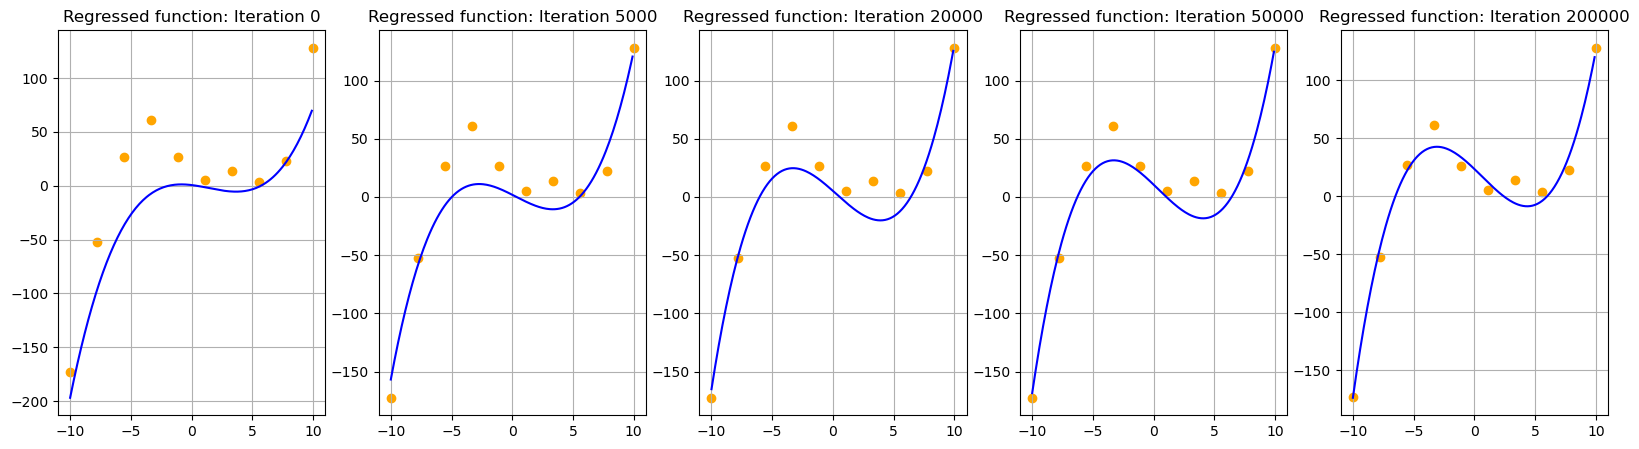

In [116]:
iter_num = np.array([0, 5000, 20000, 50000, 200000]).astype(int)
plt.figure(figsize=(20, 5))
for j, i in enumerate(iter_num):
    plt.subplot(1, 5, j+1)
    xx = np.arange(-10,10,0.1)
    curr_fn = np.zeros_like(xx)
    print(w_vals[i])
    for k in range(xx.shape[0]):
        curr_fn[k] = sum(w_vals[i][a] * xx[k]**a for a in np.arange(order+1))
    plt.plot(xx, curr_fn, color='blue')
    plt.scatter(x.detach().numpy(), t, color='orange')
    plt.grid(True)
    plt.title('Regressed function: Iteration {}'.format(i))


### Matrix solution

What's interesting is that the exact same logic we used to get the matrix solution for linear regression last lecture also works here! W just got to define a few things: 

$$
y = m_0 + m_1 x + m_2 x^2 + \cdots + m_n x^n
$$

In this equation:

- \( y \) is the dependent variable.
- \( x \) is the independent variable.
- \( m_0, m_1, m_2, \ldots, m_n \) are the coefficients of the regression model.


Now we can redefine the system: 

$$
\begin{bmatrix}
y_1 \\
y_2 \\
y_3 \\
\vdots \\
y_n
\end{bmatrix}
=
\begin{bmatrix}
1 & x_1 & x_1^2 & \cdots & x_1^m \\
1 & x_2 & x_2^2 & \cdots & x_2^m \\
1 & x_3 & x_3^2 & \cdots & x_3^m \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_n & x_n^2 & \cdots & x_n^m
\end{bmatrix}
\begin{bmatrix}
m_0 \\
m_1 \\
m_2 \\
\vdots \\
m_m
\end{bmatrix}
$$

which can then be written as 

$$ 
Y = MX 
$$


So how does this help us? Remember what we did last lecture. We had the loss: 

$$
\begin{align}
\mathcal{L} &= \arg\min_{W} \frac{1}{2} \sum_{i=1}^{N} \left( t^{(i)} - y^{(i)} \right)^2\\ 
\mathcal{L} &= \arg\min_{W} \frac{1}{2} \sum_{i=1}^{N} \left( t^{(i)} - X^{(i)} W  \right)^2 \\
\mathcal{L} &= \arg\min_{W} \frac{1}{2} \left( T - X^T W  \right)^2 \\
\mathcal{L} &= \arg\min_{W} \frac{1}{2} \left( T - X^T W  \right)^T \left( T - X^T W  \right) \\
\mathcal{L} &= \arg\min_{W} \frac{1}{2} \left( T^T T - T^T X^T W - W^T X T + W^T X X^T W \right) \\
\end{align}
$$

to find the minimum we take the derivative of the loss and set it equal to zero: 

$$
\begin{align}
    \frac{\partial \mathcal{L}}{\partial W} = 0 &= 0 - T^T X^T - X T + 2 X X^T W \\
                                                &= - X T - X T + 2 X X^T W \\
                                             2XT &= 2 X X^T W \\
                                             X X^T W &= XT \\
                                             W &= \left(X X^T\right)^-1 X T
\end{align}
$$

this means that using the exact same logic as last lecture, we get: 

$$
W = \left(X^TX\right)^{-1}X^T t
$$

(Both formulations are correct, just depends on how you define the initial loss function. Thought I'd show an alternate formulation) 

In [135]:
def polynomial_to_string(coefficients):
    """
    Converts a list of coefficients into a polynomial equation string with coefficients
    formatted to two decimal places.

    Parameters:
    coefficients (list or array): Coefficients of the polynomial, where the index represents the power of x.

    Returns:
    str: A string representation of the polynomial equation.
    """
    terms = []
    degree = len(coefficients) - 1

    for power, coeff in enumerate(coefficients):
        if coeff == 0:
            continue  # Skip zero coefficients

        # Determine the sign
        sign = '+' if coeff > 0 else '-'

        # Format the coefficient to two decimal places
        abs_coeff = abs(coeff)
        if abs_coeff == 1 and power != 0:
            coeff_str = ''
        else:
            coeff_str = f'{abs_coeff:.2f}'

        # Format the variable part
        if power == 0:
            variable_str = ''
        elif power == 1:
            variable_str = 'x'
        else:
            variable_str = f'x^{power}'

        # Combine parts
        if terms:
            term = f' {sign} {coeff_str}{variable_str}'
        else:
            term = f'{coeff_str}{variable_str}' if sign == '+' else f'-{coeff_str}{variable_str}'

        terms.append(term)

    # Join all terms and handle the case where all coefficients are zero
    polynomial = ''.join(terms) if terms else '0'
    return f'y = {polynomial}'

# Example usage:
coefficients = [2, -4.5678, 0, 3.14159]  # Represents 2 - 4.57x + 3.14x^3
equation = polynomial_to_string(coefficients)
print(equation)  # Output: y = 2.00 - 4.57x + 3.14x^3



y = 2.00 - 4.57x + 3.14x^3


tensor([ 28.5155, -10.0587,  -0.5440,   0.2502], dtype=torch.float64)


Text(0.5, 1.0, 'y = 28.52 - 10.06x - 0.54x^2 + 0.25x^3')

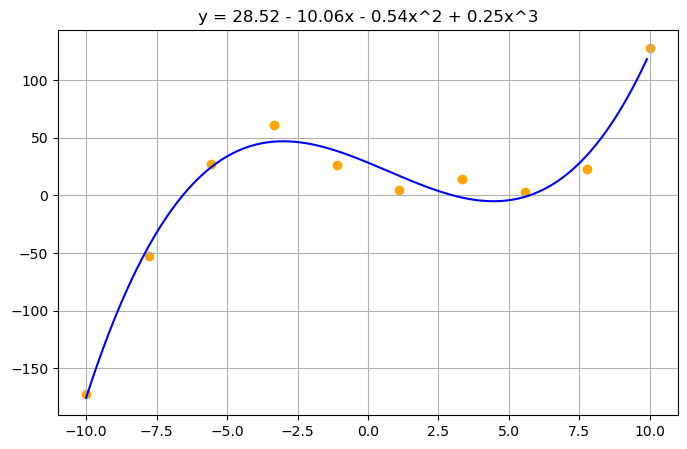

In [154]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# dataset we are artificially creating: 
# Set seed for reproducibility
np.random.seed(42)

N=10
# Generate 10 x values between 0 and 10
x = torch.linspace(-10, 10, N)

# Generate y values with some variability
def f(x): 
    return 0.25 * x **3 + -0.5 * x**2 + -10 * x + 20 

t = torch.clone(f(x) + np.random.normal(0, 15, size=len(x)))

#Set polynomial order (2 means we want a fitting function w3 x^3 + w2 x^2 + w1 x + w0)
order = 3

X = np.ones(N)
for i in range(order):
    XC = x**(i+1)
    X = np.column_stack((X, XC))
    
w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.transpose(),X)), X.transpose()), t)
print(w)
plt.figure(figsize=(8, 5))
plt.subplot(1, 1,1)
xx = np.arange(-10,10,0.1)
curr_fn = np.zeros_like(xx)
for k in range(xx.shape[0]):
    curr_fn[k] = sum(w[a] * xx[k]**a for a in np.arange(order+1))
plt.plot(xx, curr_fn, color='blue')
plt.scatter(x.detach().numpy(), t, color='orange')
plt.grid(True)
plt.title(polynomial_to_string(w))


### Beware of overfitting

With this new ability, it is tempting to just go to the highest degree polynomial that looks good, but ask yourself, is the model representative of the underlying model?

<img align="middle" src="./img/poly_fit_9.png" width="500px" style="padding:30px;border:thin solid white;">

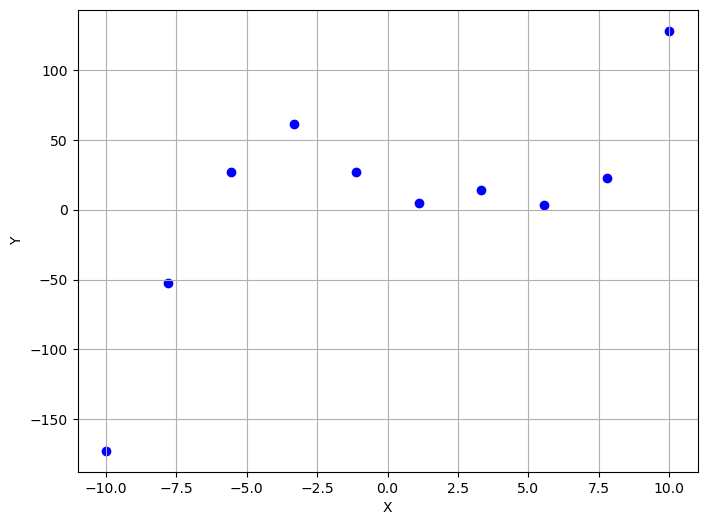

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate 10 x values between 0 and 10
x = np.linspace(-10, 10, 10)

# Generate y values with some variability
def f(x): 
    return 0.25 * x **3 + -0.5 * x**2 + -10 * x + 20 

y = f(x) + np.random.normal(0, 15, size=len(x))


# Create the figure and axis
plt.figure(figsize=(8, 6))

# Scatter plot of generated points
plt.scatter(x, y, label='Generated Data', color='blue')

# Plot the line
px = np.linspace(-10, 10, 100)
# plt.plot(px,f(px), label='y = 2x + 5', color='blue', linewidth=2)

# Labels and title
plt.xlabel('X')
plt.ylabel('Y')
#plt.ylim(0, 30)
#plt.title('Scatter Plot with Best Fit Line (Seed = 42)')
#plt.legend()
plt.grid(True)

#plt.show()

# Save the plot to a file
plt.savefig("./img/scatter_plot_with_sample_polynomial_no_lines.png", dpi=300, bbox_inches='tight')

## Regularization 

An issue with regularization? noise in data can skew certain parameters:  

<img align="middle" src="./img/reg_example_lambda=0.png" width="500px" style="padding:30px;border:thin solid white;">

Let's assume we know all the parameters are roughly the same order of magnitude. Maybe we can encourage the model to normalize the parameters to minimize one parameter getting pulled a particular way? 

We can what's called a **L2 penalty term** to the loss function, and this is called **L2 regularization**.:

$$
\mathcal{L}(w) = \sum_{i=1}^{n} \left( y^i - wx^i \right)^2 + \lambda \sum_{j=0}^{d} w_j^2
$$

where $\lambda$ is a fitting term. This is called L2 penalty just because it’s a L2-norm of \( w \). 

<img align="middle" src="./img/losses_surf.png" width="800px" style="padding:30px;border:thin solid white;">

In fancy terms, this whole loss function is also known as **Ridge regression**.

<img align="middle" src="./img/losses_contours.png" width="800px" style="padding:30px;border:thin solid white;">

Interestingly, the same matrix solution we've developed for the matrix solution can be modified to include L2 regularization: 

"First write the loss function in matrix notation:

$$
L(w) = \|y - Xw\|^2 + \lambda \|w\|^2_2
$$

Then the gradient is:

$$
\nabla L_w = -2X^T(y - Xw) + 2\lambda w
$$

Setting to zero and solving:

$$
0 = -2X^T(y - Xw) + 2\lambda w
$$

$$
= X^T(y - Xw) - \lambda w
$$

$$
= X^T y - X^T X w - \lambda w
$$

$$
= X^T y - (X^T X + \lambda I_d) w
$$

Move that to the other side and we get a closed-form solution:

$$
(X^T X + \lambda I_d) w = X^T y
$$

$$
w = (X^T X + \lambda I_d)^{-1} X^T y
$$

which is almost the same as linear regression without regularization." [2]


tensor([10.2240, -0.9197], dtype=torch.float64)


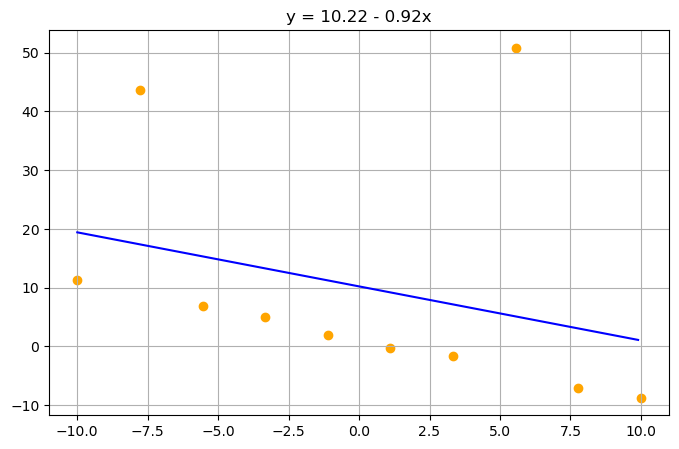

In [273]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# dataset we are artificially creating: 
# Set seed for reproducibility
np.random.seed(42)

N=10
# Generate 10 x values between 0 and 10
xlims = [-10, 10]
x = torch.linspace(xlims[0], xlims[1], N)

# Generate y values with some variability
def f(x): 
    return -1 * x + 1

random_spikes = np.zeros(N)
random_spikes[1] = 35
random_spikes[7] = 55
t = f(x) + np.random.normal(0, 0.5, size=len(x)) + random_spikes

#Set polynomial order (2 means we want a fitting function w3 x^3 + w2 x^2 + w1 x + w0)
order = 1

X = np.ones(N)
for i in range(order):
    XC = x**(i+1)
    X = np.column_stack((X, XC))

lambdaa = 0
w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.transpose(),X) + lambdaa*np.identity(order+1)), X.transpose()), t)
print(w)
plt.figure(figsize=(8, 5))
plt.subplot(1, 1,1)
xx = np.arange(min(x), max(x), 0.1)
curr_fn = np.zeros_like(xx)
for k in range(xx.shape[0]):
    curr_fn[k] = sum(w[a] * xx[k]**a for a in np.arange(order+1))
plt.plot(xx, curr_fn, color='blue')
plt.scatter(x, t, color='orange')
plt.grid(True)
plt.title(polynomial_to_string(w))

plt.savefig('./img/reg_example_lambda='+str(lambdaa))

Increasing lambda suppresses parameter values. Can be a gift or a curse  depending on your preprocessing, data, and models: 

---

<div style="display: flex; justify-content: space-around; text-align: center;">
    <div>
        <p>$\lambda = 0$</p>
        <img src="./img/reg_example_lambda=0.png" alt="Image 1" width="300">
    </div>
    <div>
        <p>$\lambda = 50$</p>
        <img src="./img/reg_example_lambda=50.png" alt="Image 2" width="300">
    </div>
    <div>
        <p>$\lambda = 1000$</p>
        <img src="./img/reg_example_lambda=1000.png" alt="Image 3" width="300">
    </div>
</div>


/var/folders/dl/klptcn0j6cz_5lxgh6mxyd_r0000gn/T/ipykernel_72388/3509197299.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


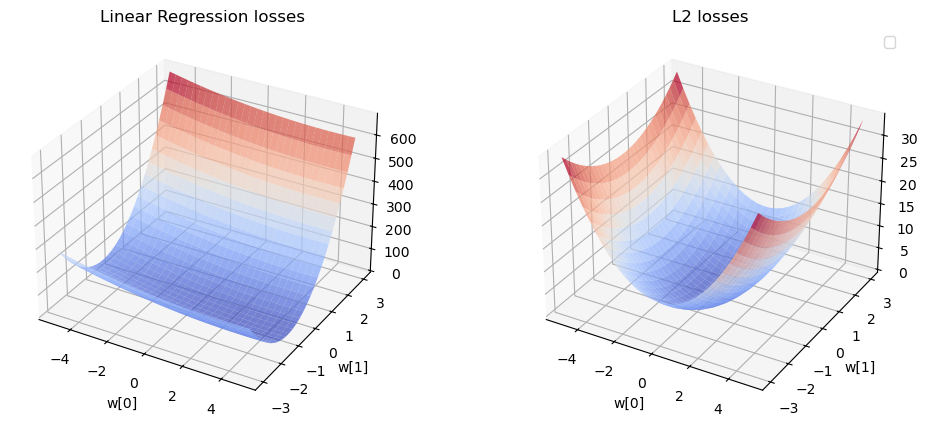

In [260]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set seed for reproducibility
np.random.seed(42)

# Generate synthetic dataset
N = 10
x = np.linspace(-10, 10, N)

def f(x): 
    return -1 * x + 2 

random_spikes = np.zeros(N)
random_spikes[8] = 10  
t = f(x) + np.random.normal(0, 2.0, size=len(x)) + random_spikes

# Define grid of m0 and m1 values
m0_vals = np.linspace(-5, 5, 30)  # Reduced resolution for efficiency
m1_vals = np.linspace(-3, 3, 30)
M0, M1 = np.meshgrid(m0_vals, m1_vals)

# Compute loss for each (m0, m1) pair efficiently
losses = np.zeros_like(M0)
L2_losses = np.zeros_like(M0)

lambda_reg = 1  # Regularization strength

for i in range(M0.shape[0]):
    for j in range(M0.shape[1]):
        y_pred = M1[i, j] * x + M0[i, j]
        loss = np.mean((y_pred - t) ** 2) + lambda_reg * (M0[i, j]**2 + M1[i, j]**2)
        losses[i, j] = np.mean((y_pred - t) ** 2)
        L2_losses[i, j] = (M0[i, j]**2 + M1[i, j]**2)

# Plot 3D surface
fig = plt.figure(figsize=(12, 5))

# Plot standard least squares loss
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(M0, M1, losses, cmap='coolwarm', alpha=0.7)
ax1.set_xlabel('w[0]')
ax1.set_ylabel('w[1]')
ax1.set_title('Linear Regression losses')

# Ridge regression plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(M0, M1, L2_losses, cmap='coolwarm', alpha=0.7)
ax2.set_xlabel('w[0]')
ax2.set_ylabel('w[1]')
ax2.set_title('L2 losses')

plt.legend()
plt.savefig("./img/losses_surf")


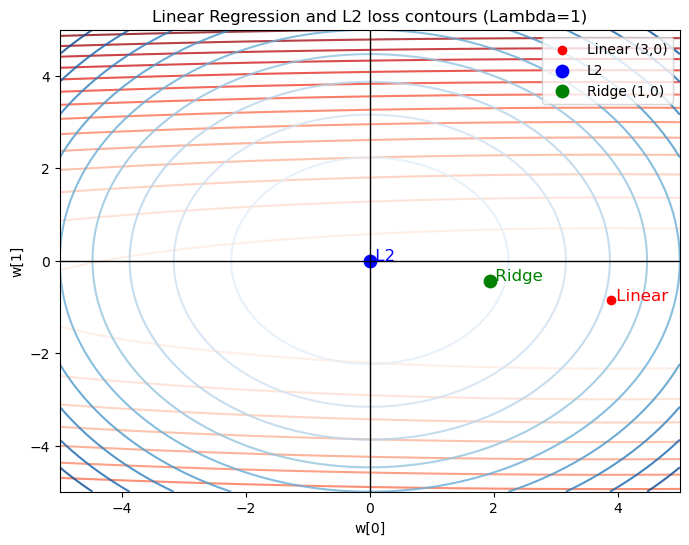

In [271]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate synthetic dataset
N = 10
x = np.linspace(-10, 10, N)

def f(x): 
    return -1 * x + 2 

random_spikes = np.zeros(N)
random_spikes[8] = 10  
t = f(x) + np.random.normal(0, 2.0, size=len(x)) + random_spikes

# Define grid of m0 and m1 values
m0_vals = np.linspace(-5, 5, 100)  # Wider range for better visualization
m1_vals = np.linspace(-5, 5, 100)
M0, M1 = np.meshgrid(m0_vals, m1_vals)

# Compute loss for each (m0, m1) pair efficiently
losses = np.zeros_like(M0)
L2_losses = np.zeros_like(M0)

lambda_reg = 1  # Regularization strength

for i in range(M0.shape[0]):
    for j in range(M0.shape[1]):
        y_pred = M1[i, j] * x + M0[i, j]
        losses[i, j] = np.mean((y_pred - t) ** 2)
        L2_losses[i, j] = (M0[i, j]**2 + M1[i, j]**2)

# Find min points
min_idx = np.unravel_index(np.argmin(losses), losses.shape)
min_m0, min_m1 = M0[min_idx], M1[min_idx]

ridge_m0 = min_m0 / (1 + lambda_reg)
ridge_m1 = min_m1 / (1 + lambda_reg)

# Create Contour Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot MSE Loss Contours (Red)
contour1 = ax.contour(M0, M1, losses, levels=15, cmap="Reds", alpha=0.8)
ax.scatter(min_m0, min_m1, color='red', label=f'Linear ({int(min_m0)},{int(min_m1)})')

# Plot L2 Regularization Loss Contours (Blue)
contour2 = ax.contour(M0, M1, L2_losses, levels=10, cmap="Blues", alpha=0.8)
ax.scatter(0, 0, color='blue', label="L2", marker='o', s=80)

# Ridge Regression Min Point
ax.scatter(ridge_m0, ridge_m1, color='green', label=f'Ridge ({int(ridge_m0)},{int(ridge_m1)})', s=80)

# Labels and Formatting
ax.axhline(0, color='black', linewidth=1)  # x-axis
ax.axvline(0, color='black', linewidth=1)  # y-axis
ax.set_xlabel("w[0]")
ax.set_ylabel("w[1]")
ax.set_title(f"Linear Regression and L2 loss contours (Lambda={lambda_reg})")

# Annotate
ax.text(min_m0, min_m1, " Linear", color='red', fontsize=12)
ax.text(ridge_m0, ridge_m1, " Ridge", color='green', fontsize=12)
ax.text(0, 0, " L2", color='blue', fontsize=12)

# Legend
ax.legend()

# Save and Show
plt.savefig("./img/losses_contours.png", dpi=300)
plt.show()


## That's it for today

Next time we'll talk about the limits of linear regression and more about logistic regression. 

## Additional References

[1] Roger Grosse CSC321 lectures - https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/
[2] Freindly ML Tutorial - Linear regression with regularization -  https://aunnnn.github.io/ml-tutorial/html/blog_content/linear_regression/linear_regression_regularized.html